In [2]:
#MacOS 兼容性操作
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM

import altair as alt

In [4]:
#load the data
data = pd.read_csv('BTC_price_train.csv')
data.head()

,timeOpen,Close,Open,High,Low,volume,Chg.(%)
0,2014/1/1,815.9,805.9,829.9,771.0,10760.0,0.01
1,2014/1/2,856.9,815.9,886.2,810.5,12810.0,0.05
2,2014/1/3,884.3,856.9,888.2,839.4,9710.0,0.03
3,2014/1/4,924.7,884.3,932.2,848.3,14240.0,0.05
4,2014/1/5,1014.7,924.7,1029.9,911.4,21370.0,0.10


In [5]:
# Display the first 5 rows
print(data.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data.info())

| timeOpen   | Close   | Open   | High   | Low   | volume   | Chg.(%)   |
|:-----------|:--------|:-------|:-------|:------|:---------|:----------|
| 2014/1/1   | 815.9   | 805.9  | 829.9  | 771   | 10760    | 0.01      |
| 2014/1/2   | 856.9   | 815.9  | 886.2  | 810.5 | 12810    | 0.05      |
| 2014/1/3   | 884.3   | 856.9  | 888.2  | 839.4 | 9710     | 0.03      |
| 2014/1/4   | 924.7   | 884.3  | 932.2  | 848.3 | 14240    | 0.05      |
| 2014/1/5   | 1014.7  | 924.7  | 1029.9 | 911.4 | 21370    | 0.1       |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  3057 non-null   object 
 1   Close     3057 non-null   float64
 2   Open      3057 non-null   float64
 3   High      3057 non-null   float64
 4   Low       3057 non-null   float64
 5   volume    3057 non-null   float64
 6   Chg.(%)   3057 non-null   float64
dtypes: float64(6), objec

In [6]:
#define the data
#open_price = data.loc[:, 'Open']
close_price = data.loc[:, 'Close']
#volume = data.loc[:, 'volume']
#high_price = data.loc[:, 'High']
#low_price = data.loc[:, 'Low']

price = data.drop(['timeOpen', 'Chg.(%)'], axis=1)
print(price)
print(price.shape)



        Close     Open     High      Low    volume
0       815.9    805.9    829.9    771.0   10760.0
1       856.9    815.9    886.2    810.5   12810.0
2       884.3    856.9    888.2    839.4    9710.0
3       924.7    884.3    932.2    848.3   14240.0
4      1014.7    924.7   1029.9    911.4   21370.0
...       ...      ...      ...      ...       ...
3052  29068.2  31008.0  32113.6  27835.5  296900.0
3053  28976.0  29073.4  30136.7  26500.5  309480.0
3054  29284.4  28994.3  31002.7  28755.0  141230.0
3055  30080.4  29285.2  30277.4  28666.7   70460.0
3056  31308.7  30078.6  31383.8  29499.4   65440.0

[3057 rows x 5 columns]
(3057, 5)


In [7]:
#normalize
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler.fit_transform(price)

print(scaled_price)
print(scaled_price.shape)

#scaled_close_price = scaled_price[:, 0]
#print(scaled_close_price)
#print(scaled_close_price.shape)


[[1.04470284e-02 1.02985741e-02 9.73115116e-03 1.02546375e-02
  2.34899343e-06]
 [1.10551899e-02 1.04469044e-02 1.05491025e-02 1.08509251e-02
  2.80760643e-06]
 [1.14616198e-02 1.10550587e-02 1.05781594e-02 1.12871963e-02
  2.11409408e-06]
 ...
 [4.32726210e-01 4.28418013e-01 4.48094958e-01 4.32697998e-01
  3.15369146e-05]
 [4.44533444e-01 4.32732942e-01 4.37557478e-01 4.31365031e-01
  1.57046989e-05]
 [4.62753073e-01 4.44501469e-01 4.53631748e-01 4.43935378e-01
  1.45816563e-05]]
(3057, 5)


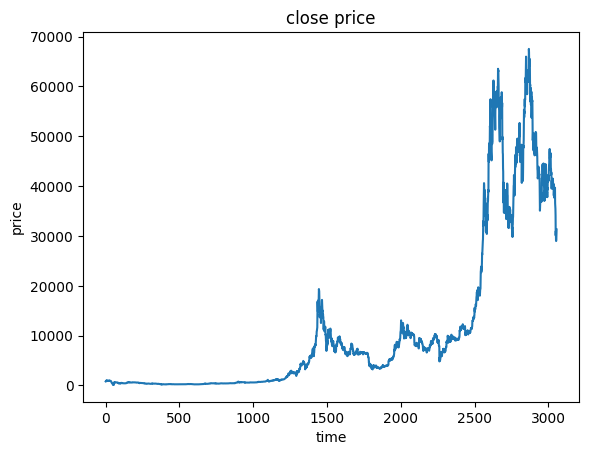

In [7]:
#visualization
fig1 = plt.figure()
plt.plot(close_price)
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [12]:
#define method to extract X and y
def extract_data(data, time_step):
    X = []
    y = []
    for i in range(len(data) - time_step):
        X.append([a for a in data[i: i + time_step]])
        y.append(data[i + time_step, :]) 
    X = np.array(X)
    #转化成RNN格式 (样本数,timestep, 每个数据的维度(特征数))
    #X = X.reshape(X.shape[0], time_step, X.shape[2])
    y = np.array(y)
    return X, y

In [13]:
time_step = 30
#define X and y
X, y = extract_data(scaled_price, time_step)
print(X.shape, y.shape)

(3027, 30, 5) (3027, 5)


In [14]:
#set up the model

model = Sequential()
#add LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 5), activation='relu'))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(units=25, activation='linear'))
#add output layer
model.add(Dense(5))
#configure the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,805 (128.14 KB)

 Trainable params: 32,805 (128.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#train the model
model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 53s 531ms/step - loss: 0.0117
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 518ms/step - loss: 8.4339e-04
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 521ms/step - loss: 8.8009e-04
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 542ms/step - loss: 5.9884e-04
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 53s 562ms/step - loss: 5.4917e-04
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 55s 579ms/step - loss: 5.4606e-04
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 52s 548ms/step - loss: 5.2931e-04
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 522ms/step - loss: 4.4898e-04
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 52s 540ms/step - loss: 3.3707e-04
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 512ms/step - loss: 4.4677e-04
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 513ms/step - loss: 3.0582e-04
Epoch 12/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 514ms/step - loss: 4.8709e-04
Epoch 13/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 514ms/step - loss: 2.7971e-04
Epoch 14/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 49s 512ms/step - loss: 5.

In [16]:


model.save('BTC_predict_test3.h5')
model.save('BTC_predict_test3.keras')

In [18]:
#make prediction on the training data
y_train_predictions = model.predict(X)

# 反归一化预测结果
y_train_predictions = scaler.inverse_transform(y_train_predictions)
y_train_predictions_close = y_train_predictions[:, 0]

print(y_train_predictions.shape)
print(y_train_predictions_close.shape)

95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step
(3027, 5)
(3027,)


In [30]:
# 反归一化实际结果
y_train = scaler.inverse_transform(y)

print(y_train.shape)
print(y_train)

y_train_close = y_train[:, 0]
print(y_train_close)


time = list(range(len(y_train_close)))
print(time)

(3027, 5)
[[   938.8    941.4    954.7    924.6   4310. ]
 [   940.4    938.8    969.2    927.8   4370. ]
 [   953.3    940.4    959.4    934.4   1580. ]
 ...
 [ 29284.4  28994.3  31002.7  28755.  141230. ]
 [ 30080.4  29285.2  30277.4  28666.7  70460. ]
 [ 31308.7  30078.6  31383.8  29499.4  65440. ]]
[  938.8   940.4   953.3 ... 29284.4 30080.4 31308.7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 1

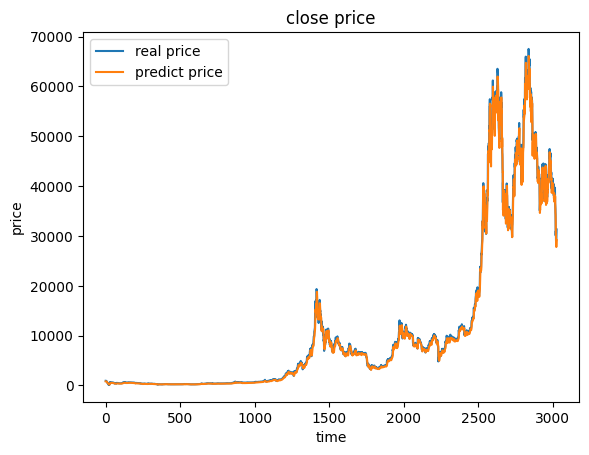

In [31]:
#visualization
fig2 = plt.figure()
plt.plot(time, y_train_close, label='real price')
plt.plot(time, y_train_predictions_close, label='predict price')
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [32]:
#load the test data
data_test = pd.read_csv('BTC_price_test.csv')

# Reverse the order of the DataFrame
#data_test = data_test.iloc[::-1].reset_index(drop=True)
# Display the first 5 rows
print(data_test.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data_test.info())

| timeOpen   | Close   | Open    | High    | Low     | volume   | Chg.(%)   |
|:-----------|:--------|:--------|:--------|:--------|:---------|:----------|
| 2022/5/16  | 29849   | 31308.3 | 31312.4 | 29135.8 | 100250   | -0.05     |
| 2022/5/17  | 30437.5 | 29856.7 | 30720.1 | 29484.5 | 79630    | 0.02      |
| 2022/5/18  | 28683.7 | 30437.5 | 30687.9 | 28648.1 | 92030    | -0.06     |
| 2022/5/19  | 30305.9 | 28700.4 | 30525.1 | 28682.1 | 101380   | 0.06      |
| 2022/5/20  | 29178.6 | 30305.9 | 30735.1 | 28738.5 | 98780    | -0.04     |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  764 non-null    object 
 1   Close     764 non-null    float64
 2   Open      764 non-null    float64
 3   High      764 non-null    float64
 4   Low       764 non-null    float64
 5   volume    764 non-null    float64
 6   Chg.(%)   764 non-null    float64

In [33]:
#define the price
price_test = data_test.drop(['timeOpen', 'Chg.(%)'], axis=1)

#normalize
scaled_test_data = scaler.transform(price_test)  # 使用在训练集上拟合的scaler来转换测试集

print(scaled_test_data.shape)
print(scaled_test_data)

(764, 5)
[[4.41101039e-01 4.62741649e-01 4.52594417e-01 4.38446512e-01
  2.23691288e-05]
 [4.49830382e-01 4.41210019e-01 4.43989220e-01 4.43710449e-01
  1.77561532e-05]
 [4.23815902e-01 4.49825044e-01 4.43521404e-01 4.31084247e-01
  2.05302025e-05]
 ...
 [9.80644147e-01 9.77830550e-01 9.63036735e-01 9.93360828e-01
  5.32214796e-06]
 [9.87344307e-01 9.80632510e-01 9.70373599e-01 9.95519540e-01
  4.58165575e-06]
 [9.72215918e-01 9.87305891e-01 9.69525138e-01 9.87240955e-01
  7.90604073e-06]]


In [47]:
X_test, y_test = extract_data(scaled_test_data, time_step)

print(X_test.shape, y_test.shape)
print(X_test, y_test)

(734, 30, 5) (734, 5)
[[[4.41101039e-01 4.62741649e-01 4.52594417e-01 4.38446512e-01
   2.23691288e-05]
  [4.49830382e-01 4.41210019e-01 4.43989220e-01 4.43710449e-01
   1.77561532e-05]
  [4.23815902e-01 4.49825044e-01 4.43521404e-01 4.31084247e-01
   2.05302025e-05]
  ...
  [3.93001396e-01 4.19662074e-01 4.12240213e-01 4.00261461e-01
   2.67919479e-05]
  [3.31320467e-01 3.92996732e-01 3.87873109e-01 3.30820371e-01
   8.47874770e-05]
  [3.27008453e-01 3.31332852e-01 3.34738234e-01 3.13529540e-01
   5.60962001e-05]]

 [[4.49830382e-01 4.41210019e-01 4.43989220e-01 4.43710449e-01
   1.77561532e-05]
  [4.23815902e-01 4.49825044e-01 4.43521404e-01 4.31084247e-01
   2.05302025e-05]
  [4.47878332e-01 4.24058585e-01 4.41156173e-01 4.31597507e-01
   2.26219253e-05]
  ...
  [3.31320467e-01 3.92996732e-01 3.87873109e-01 3.30820371e-01
   8.47874770e-05]
  [3.27008453e-01 3.31332852e-01 3.34738234e-01 3.13529540e-01
   5.60962001e-05]
  [3.33247301e-01 3.26710879e-01 3.28260001e-01 3.02432552e-01

In [48]:
#predict
y_test_predict = model.predict(X_test)
print(y_test_predict.shape)
print(y_test_predict)
y_test_predict = scaler.inverse_transform(y_test_predict)
print(y_test_predict.shape)
print(y_test_predict)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
(734, 5)
[[ 0.32269332  0.32144007  0.33089203  0.31231523 -0.00178555]
 [ 0.31500095  0.3145818   0.32369864  0.3055791  -0.00243304]
 [ 0.3067196   0.3063857   0.31506974  0.29783306 -0.00238841]
 ...
 [ 0.9490039   0.9640849   0.9634847   0.9528645  -0.00736197]
 [ 0.95512635  0.96999186  0.9692116   0.95961106 -0.007162  ]
 [ 0.9601481   0.9744583   0.973606    0.9651475  -0.00667094]]
(734, 5)
[[ 2.1866391e+04  2.1782158e+04  2.2935564e+04  2.0780459e+04
  -7.9811465e+06]
 [ 2.1347799e+04  2.1319793e+04  2.2440439e+04  2.0334236e+04
  -1.0875420e+07]
 [ 2.0789502e+04  2.0767234e+04  2.1846508e+04  1.9821115e+04
  -1.0675931e+07]
 ...
 [ 6.4089930e+04  6.5107406e+04  6.6477234e+04  6.3212496e+04
  -3.2907736e+07]
 [ 6.4502684e+04  6.5505637e+04  6.6871422e+04  6.3659410e+04
  -3.2013884e+07]
 [ 6.4841234e+04  6.5806750e+04  6.7173891e+04  6.4026160e+04
  -2.9818840e+07]]


In [49]:
print(y_test)
y_test = scaler.inverse_transform(y_test)
print(y_test.shape)
print(y_test)

y_test_predict_close = y_test_predict[:, 0]
y_test_close = y_test[:, 0]

[[3.33247301e-01 3.26710879e-01 3.28260001e-01 3.02432552e-01
  6.26733817e-05]
 [3.00743292e-01 3.33243346e-01 3.30986990e-01 3.04022149e-01
  3.21566014e-05]
 [3.01603618e-01 3.00809439e-01 3.07353571e-01 3.04218395e-01
  3.04272948e-05]
 ...
 [9.80644147e-01 9.77830550e-01 9.63036735e-01 9.93360828e-01
  5.32214796e-06]
 [9.87344307e-01 9.80632510e-01 9.70373599e-01 9.95519540e-01
  4.58165575e-06]
 [9.72215918e-01 9.87305891e-01 9.69525138e-01 9.87240955e-01
  7.90604073e-06]]
(734, 5)
[[ 22577.9  22137.5  22754.4  20125.8 280410. ]
 [ 20386.6  22577.9  22942.1  20231.1 144000. ]
 [ 20444.6  20391.3  21315.4  20244.1 136270. ]
 ...
 [ 66223.   66034.1  66446.4  65895.1  24050. ]
 [ 66674.7  66223.   66951.4  66038.1  20740. ]
 [ 65654.8  66672.9  66893.   65489.7  35600. ]]


In [51]:
print(y_test_predict_close[0])
print(y_test_close[0])

21866.39
22577.9


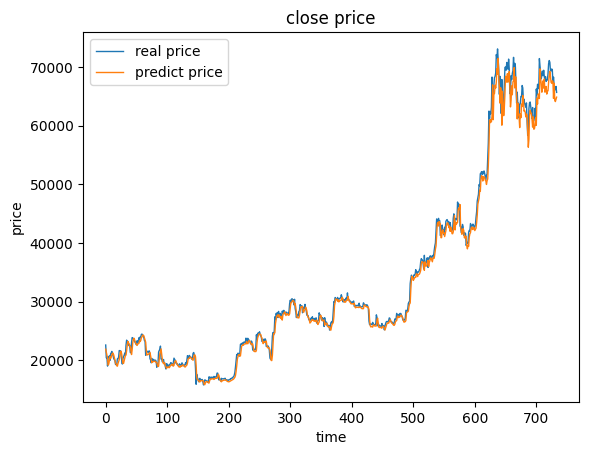

In [52]:
time_test = list(range(len(y_test_close)))

fig3 = plt.figure()
plt.plot(time_test, y_test_close, label='real price',linewidth = 1)
plt.plot(time_test, y_test_predict_close, label='predict price', lw = 1)
plt.legend()
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()


In [53]:
'''
#输出结果
result_y_test = y_test.reshape(-1, 1)
result_y_predict = y_test_predict.reshape(-1, 1)

print(y_test.shape, result_y_test.shape, y_test_predict.shape)

result = np.concatenate((result_y_test, result_y_predict), axis=1)
print(result.shape)

result = pd.DataFrame(result, columns=['real_price_test', 'predict_price_test'])
result.to_csv('BTC_predict_test_2.0.csv')
'''

"\n#输出结果\nresult_y_test = y_test.reshape(-1, 1)\nresult_y_predict = y_test_predict.reshape(-1, 1)\n\nprint(y_test.shape, result_y_test.shape, y_test_predict.shape)\n\nresult = np.concatenate((result_y_test, result_y_predict), axis=1)\nprint(result.shape)\n\nresult = pd.DataFrame(result, columns=['real_price_test', 'predict_price_test'])\nresult.to_csv('BTC_predict_test_2.0.csv')\n"

In [54]:
#进行迭代预测
data_30d = pd.read_csv('BTC_30D.csv')

# Reverse the order of the DataFrame
#data_30d = data_30d.iloc[::-1].reset_index(drop=True)
# Display the first 5 rows
print(data_30d.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column names and their data types
print(data_30d.info())

| timeOpen   | Close   | Open    | High    | Low     | volume   | Chg.(%)   |
|:-----------|:--------|:--------|:--------|:--------|:---------|:----------|
| 2024/5/19  | 66279.1 | 66919   | 67662.5 | 65937.3 | 36190    | -0.01     |
| 2024/5/20  | 71422.7 | 66278.3 | 71482.8 | 66076.5 | 112660   | 0.08      |
| 2024/5/21  | 70139.9 | 71430.5 | 71872   | 69181.7 | 108560   | -0.02     |
| 2024/5/22  | 69155.4 | 70141   | 70593.4 | 69024.3 | 65080    | -0.01     |
| 2024/5/23  | 67975.7 | 69166.3 | 70041   | 66578.1 | 89450    | -0.02     |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   timeOpen  30 non-null     object 
 1   Close     30 non-null     float64
 2   Open      30 non-null     float64
 3   High      30 non-null     float64
 4   Low       30 non-null     float64
 5   volume    30 non-null     float64
 6   Chg.(%)   30 non-null     float64
d

In [55]:
price_30d = data_30d.drop(['timeOpen', 'Chg.(%)'], axis=1)

scaled_30d_data = scaler.transform(price_30d)

print(scaled_30d_data.shape)
print(type(scaled_30d_data))

(30, 5)
<class 'numpy.ndarray'>


In [56]:
scaled_30d_data = scaled_30d_data.reshape(1, 30, 5)
print(scaled_30d_data.shape)
print(scaled_30d_data)

(1, 30, 5)
[[[9.81476290e-01 9.90956300e-01 9.80704775e-01 9.93997874e-01
   8.03803179e-06]
  [1.05777238e+00 9.81452777e-01 1.03620779e+00 9.96099222e-01
   2.51454153e-05]
  [1.03874434e+00 1.05787552e+00 1.04186226e+00 1.04297498e+00
   2.42281893e-05]
  [1.02414105e+00 1.03874833e+00 1.02328619e+00 1.04059888e+00
   1.45011194e-05]
  [1.00664231e+00 1.02429057e+00 1.01526068e+00 1.00367132e+00
   1.99530213e-05]
  [1.01512542e+00 1.00656213e+00 1.00321660e+00 1.00529715e+00
   1.40984348e-05]
  [1.02605453e+00 1.01512228e+00 1.00825506e+00 1.03292715e+00
   5.57270726e-06]
  [1.01463889e+00 1.02608389e+00 1.00731362e+00 1.02958190e+00
   5.44071620e-06]
  [1.02819496e+00 1.01462389e+00 1.02393852e+00 1.02929055e+00
   1.09194637e-05]
  [1.01243171e+00 1.02817683e+00 1.00828267e+00 1.01456753e+00
   1.59127526e-05]
  [1.00160050e+00 1.01242266e+00 9.98648855e-01 1.01220201e+00
   1.16040275e-05]
  [1.01226410e+00 1.00152187e+00 1.00746907e+00 1.01212955e+00
   1.48948555e-05]
  [1.

In [57]:
#定义函数
def predict_and_update(model, scaled_30d_data, num_predictions):
    """
    使用模型进行多次预测，并在每次预测后更新输入数据。

    参数:
        model: 训练好的预测模型。
        scaled_30d_data: 初始的归一化价格数据，形状为 (1, 30, 5)。
        num_predictions: 要进行的预测次数。

    返回:
        所有预测结果组成的列表。
    """
    predictions = []
    for _ in range(num_predictions):
        # 预测
        predict_30d = model.predict(scaled_30d_data)

        # 转换 predict_30d 的形状并拼接
        scaled_30d_data = np.concatenate([scaled_30d_data, predict_30d.reshape(1, 1, 5)], axis=1)

        # 删除第一个元素
        scaled_30d_data = scaled_30d_data[:, 1:]

        predictions.append(predict_30d)

    return predictions

In [69]:
a = predict_and_update(model, scaled_30d_data, 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━

In [70]:
a = np.array(a)
print(a.shape)
a_reshape = a.reshape(30, 5)
a_reshape_result = scaler.inverse_transform(a_reshape)
#print(a_reshape_result)
a_close_result = a_reshape_result[:, 0]
print(a_close_result)

(30, 1, 5)
[63787.41  61794.58  59984.63  58401.29  56997.914 55736.047 54595.535
 53566.477 52643.242 51821.137 51095.164 50459.477 49907.258 49431.438
 49024.73  48679.88  48389.586 48146.75  47944.625 47777.207 47638.227
 47518.062 47408.723 47305.05  47204.02  47104.074 47004.78  46906.17
 46808.305 46711.184]


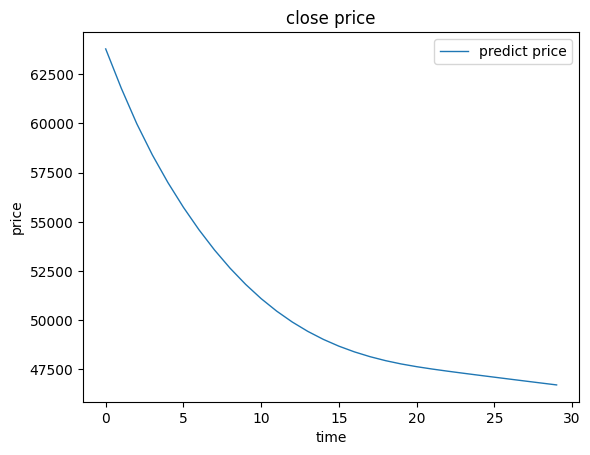

In [71]:
time_result = list(range(len(a_close_result)))

fig4 = plt.figure()
plt.plot(time_result, a_close_result, label='predict price',linewidth = 1)
plt.legend()
plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [8]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']